In [16]:
# Global
import sys
sys.path.append('../')
from src.dataset.preprocess import get_all_dataset
import pandas as pd
from sklearn.metrics import roc_auc_score
import os
import numpy as np
from lifelines.utils import concordance_index
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import scipy.stats

plt.style.use('../src/tools/dis.mplstyle')

order = ['pathgraphomic', 'pathomic', 'graphomic', 'graph', 'omic', 'path']

with open('published_results.pkl', 'rb') as f:
    published_results = pd.read_pickle(f)

grad_pub_all = published_results['grade']
surv_pub_all = published_results['survival']

In [17]:
# Get confidence intervals as values and strings

def mu_CI(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, h

def CI_pm_str(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return str("{0:.4f} ± ".format(m) + "{0:.3f}".format(h))

In [18]:

# Helper functions for plotting
def get_test_pats_shared(task):
    """
    Gets the shared test patients (ie, the union of test sets of all models)
    for a given task.
    """

    data_dir = '../data'
    rmomics = 1
    rmgrade, rna = (0, True) if task == 'surv' else (1, False)
    _, dataset = get_all_dataset(
        use_rnaseq=rna, rm_missing_omics=rmomics, rm_missing_grade=rmgrade, data_dir=data_dir, verbose=False
    )
    pnas_splits = pd.read_csv(f"{data_dir}/splits/pnas_splits.csv")
    pnas_splits.columns = ["TCGA ID"] + [k for k in range(1, 16)]
    pnas_splits.set_index("TCGA ID", inplace=True)
    pnas_splits = pnas_splits.applymap(lambda x: x.lower())
    test_pats = {}
    for fold in range(1, 16):
        test_pats[fold] = pnas_splits[(pnas_splits[fold] == 'test') & (pnas_splits.index.isin(dataset.index))].index
    return test_pats

def get_scores(task, dir='../checkpoints', shared_test_set=True):
    """Returns an array of c-index/auc scores for each fold for each model."""

    assert task in ['grad', 'surv']
    test_pats = get_test_pats_shared(task) if shared_test_set else None
    results = {}
    for model in os.listdir(f'{dir}/{task}'):
        if model[0] == '.' or model == 'results':
            continue
        scores = []
        for fname in os.listdir(f'{dir}/{task}/{model}/results'):
            fold = int(fname.split('_')[1].split('.')[0])
            all_preds = pd.read_csv(f'{dir}/{task}/{model}/results/{fname}')
            if shared_test_set:
                assert test_pats[fold].isin(all_preds['patname']).all()
                all_preds = all_preds[all_preds['patname'].isin(test_pats[fold])]
            else:
                all_preds = all_preds[all_preds['split'] == 'Test']
            if task == 'grad':
                grade_logits = all_preds[["grade_p_0", "grade_p_1", "grade_p_2"]].values
                scores.append(roc_auc_score(pd.get_dummies(all_preds["grade"]), grade_logits, average="micro"))
            else:
                scores.append(concordance_index(all_preds["time"], -all_preds["hazard_pred"], all_preds["event"]))
        results[model] = np.array(scores)
    return results

def make_results_dfs(task, shared_test_set=True):
    """Returns a tuple of dataframes, one with the results and one with the errors."""

    results = get_scores(task, shared_test_set=shared_test_set)
    for model, scores in results.items():
        results[model] = [*mu_CI(scores)]
    results = pd.Series(results).sort_values(ascending=False)
    models = results.index.map(lambda x: x.split('_')[0]).unique()
    res_table = {model: [np.nan] * 6 for model in models}
    err_table = {model: [np.nan] * 6 for model in models}
    for model in results.index:
        mname = model.split('_')[0]
        if mname == 'omic':
            res_table[mname][0] = results[model][0]
            err_table[mname][0] = results[model][1]
        else:
            mil = model.split('_')
            if 'global' in mil:
                if 'attn' in mil:
                    res_table[mname][2] = results[model][0]
                    err_table[mname][2] = results[model][1]
                elif 'qbt' in mil:
                    res_table[mname][5] = results[model][0]
                    err_table[mname][5] = results[model][1]
                else:
                    res_table[mname][1] = results[model][0]
                    err_table[mname][1] = results[model][1]
            elif 'local' in mil:
                if 'LSE' in mil:
                    res_table[mname][4] = results[model][0]
                    err_table[mname][4] = results[model][1]
                else:
                    res_table[mname][3] = results[model][0]
                    err_table[mname][3] = results[model][1]
            else:
                res_table[mname][0] = results[model][0]
                err_table[mname][0] = results[model][1]
    tables = [res_table, err_table]
    for i in range(len(tables)):
        tables[i] = pd.DataFrame(tables[i]).T
        tables[i].columns = ['PFS', 'Global', 'Global Attention', 'Local', 'Local LSE', 'QBT']
        tables[i] = tables[i] * 100
        tables[i] = tables[i].round(3)
        tables[i] = tables[i].reindex(order)
    res_table, err_table = tables

    return res_table, err_table

def make_published_df(task):
    """Makes the published results dataframe. Columns are Score and Error."""
    if task == 'grad':
        published = [[n, *mu_CI(s)] for n, s in grad_pub_all.items()]
    else:
        published = [[n, *mu_CI(s)] for n, s in surv_pub_all.items()]
    published = pd.DataFrame(published)
    published.columns = ['Model', 'Score', 'Error']
    published.set_index('Model', inplace=True)
    published = published.reindex(order)
    published = published * 100
    return published

def get_pvals(task):
    """Calculates the p-values for reproduced vs published results."""

    pvals = {}
    results = get_scores(task)
    if task == 'grad':
        for model, scores in grad_pub_all.items():
            mkey = f'{model}_PFS' if model != 'omic' else 'omic'
            pvals[model] = scipy.stats.ttest_rel(scores, results[mkey])[1]
    elif task == 'surv':
        for model, scores in surv_pub_all.items():
            mkey = f'{model}_rna_PFS' if 'omic' in model else f'{model}_PFS'
            mkey = 'omic_rna' if model == 'omic' else mkey
            pvals[model] = scipy.stats.ttest_rel(results[mkey], scores)[1]
    else:
        raise ValueError("Invalid task.")
    return pvals

def pval_list(task):
    l = []
    pval_dict = get_pvals(task)
    for m in order:
        l.append(pval_dict[m])
    return l

/var/folders/s9/505j09t9151g87v3xy2nmlb40000gn/T/ipykernel_33641/4137253272.py:17: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  pnas_splits = pnas_splits.applymap(lambda x: x.lower())
/var/folders/s9/505j09t9151g87v3xy2nmlb40000gn/T/ipykernel_33641/4137253272.py:17: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  pnas_splits = pnas_splits.applymap(lambda x: x.lower())


Adding RNAseq data


/var/folders/s9/505j09t9151g87v3xy2nmlb40000gn/T/ipykernel_33641/4137253272.py:17: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  pnas_splits = pnas_splits.applymap(lambda x: x.lower())


Adding RNAseq data


/var/folders/s9/505j09t9151g87v3xy2nmlb40000gn/T/ipykernel_33641/4137253272.py:17: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  pnas_splits = pnas_splits.applymap(lambda x: x.lower())


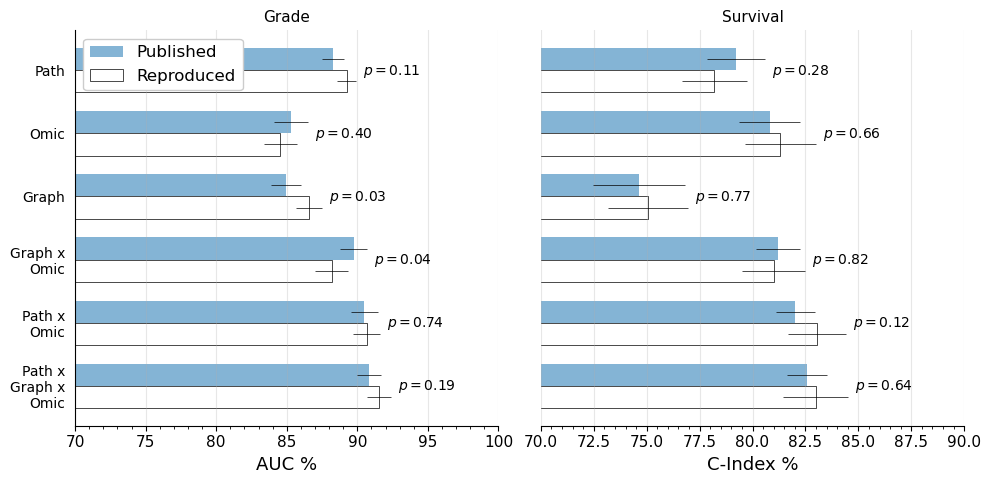

In [19]:
# Plot of published vs reproduced results
fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharey=True)
for i, task in enumerate(['grad', 'surv']):
    res_table, err_table = make_results_dfs(task)
    published = make_published_df(task)
    width = 0.35
    offset = width 
    positions = np.arange(len(order))
    ekwargs = dict(ecolor='black', capsize=0, capthick=1, elinewidth=0.5)
    kwargs = dict(height=width, error_kw=ekwargs, lw=0.5)
    bars = ax[i].barh(positions + offset/2, published['Score'], label='Published', xerr=published['Error'], color='tab:blue', alpha=0.55, **kwargs)
    ax[i].barh(positions - offset/2, res_table['PFS'], label='Reproduced', xerr=err_table['PFS'], **kwargs, fill=True, color='white', edgecolor='black')
    ax[i].set_yticks(positions)
    ax[i].set_yticklabels(['Path x\nGraph x\nOmic', 'Path x\nOmic', 'Graph x\nOmic', 'Graph', 'Omic', 'Path'], fontsize=10)
    ax[i].grid(alpha=0.3, zorder=-100, axis='x')
    pvals = pval_list(task)
    pval_x = np.stack([res_table['PFS'].to_numpy() + err_table['PFS'].to_numpy(), published['Score'].to_numpy() + published['Error'].to_numpy()]).max(axis=0)
    for j, bar in enumerate(bars):
        ax[i].annotate(f'$p={pvals[j]:.2f}$', (pval_x[j], bar.get_y()-0.01), 
                       textcoords="offset points", xytext=(5,0), ha='left', va='center', fontsize=10)
    if task == 'grad':
        ax[i].set_xlabel('AUC %')
        ax[i].set_xlim(70, 100)
        ax[i].set_title('Grade', fontsize=11)
    else:
        ax[i].set_xlabel('C-Index %')
        ax[i].set_xlim(70, 90)
        ax[i].set_title('Survival', fontsize=11)

    for a in ax:
        a.spines['top'].set_visible(False)
        a.spines['right'].set_visible(False)
        a.tick_params(axis='y', which='both', left=False, right=False)
        a.tick_params(axis='x', which='both', bottom=True, top=False)
    ax[1].spines['left'].set_visible(False)
ax[0].legend(loc='upper left', framealpha=1)
plt.tight_layout()
plt.savefig('../report/figures/reproduction.png')

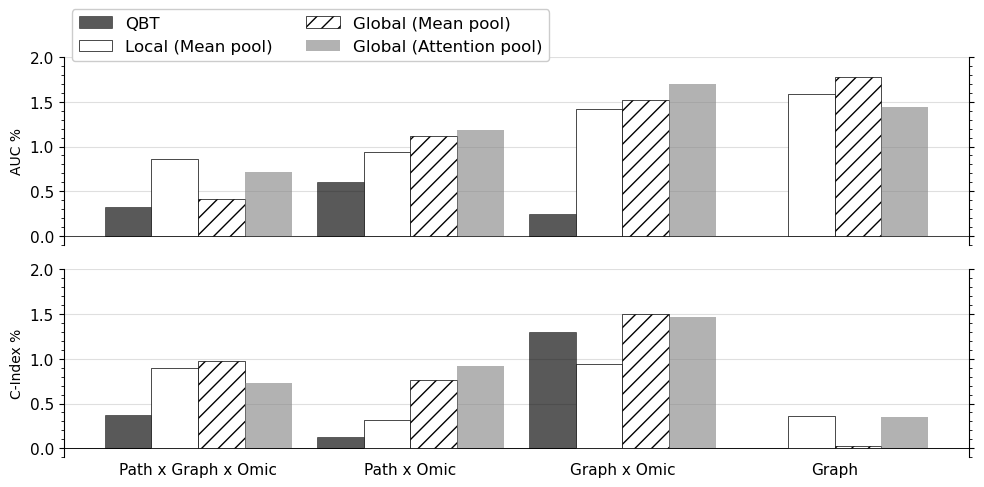

In [20]:
# Plot as performance change from PFS

fig, ax = plt.subplots(2, 1, figsize=(10, 5), sharex=True)

res, error = make_results_dfs('grad', shared_test_set=False)
res = res[:4]
error = error[:4]
width = 0.22
offset = width 
pos = np.arange(len(order))[:4]
ekwargs = dict(ecolor='black', capsize=3, capthick=1, elinewidth=0.5)
kwargs = dict(width=width, error_kw=ekwargs, zorder=100, lw=0.5)

# ax[0].bar(pos - offset*2, res['Local Maxpool'] - res['PFS'], **kwargs, ec='teal', fill=False, hatch='///', label='Local Max-pool')
ax[0].bar(pos- 1.5* offset, res['QBT'] - res['PFS'], **kwargs, color='black', alpha=0.65,  ec='k', label='QBT')
ax[0].bar(pos - 0.5* offset, res['Local'] - res['PFS'], **kwargs, color='white', ec='black', label='Local (Mean pool)')
ax[0].bar(pos + 0.5* offset, res['Global'] - res['PFS'], **kwargs, ec='black', color='white', hatch='//', label='Global (Mean pool)')
ax[0].bar(pos + 1.5*offset, res['Global Attention'] - res['PFS'], **kwargs, color='grey', alpha=0.6, label='Global (Attention pool)')

res, error = make_results_dfs('surv', shared_test_set=False)
res = res[:4]
error = error[:4]
ax[1].bar(pos- 1.5* offset, res['QBT'] - res['PFS'], **kwargs, color='black', alpha=0.65, ec='k', label='QBT')
ax[1].bar(pos - 0.5* offset, res['Local'] - res['PFS'], **kwargs, color='white', ec='black', label='Local Meanpool')
ax[1].bar(pos + 0.5* offset,res['Global'] - res['PFS'], **kwargs, ec='black', color='white', hatch='//', label='Global')
ax[1].bar(pos + 1.5*offset, res['Global Attention'] - res['PFS'], **kwargs, color='grey', alpha=0.6, label='Global Attention')

for a in ax:
    a.grid(alpha=0.4, zorder=-100, axis='y')
    a.set_xticks(pos[:4])
    a.axhline(0, color='black', lw=0.5)
    a.spines['top'].set_visible(False)  # Remove top axis line
    a.spines['bottom'].set_visible(False) 
    a.tick_params(axis='x', which='both', length=0)
    a.set_ylim(-0.1, 2)

ax[1].set_xticklabels(['Path x Graph x Omic', 'Path x Omic', 'Graph x Omic', 'Graph'], fontsize=11)
ax[0].set_ylabel('AUC %', fontsize=10)
ax[0].legend(loc='upper left', bbox_to_anchor=(0, 1.3),  framealpha=1, ncols=2)
ax[1].set_ylabel('C-Index %', fontsize=10)
ax[1].axhline(0, color='black', lw=0.5)

plt.tight_layout()
plt.savefig('../report/figures/MIL_performance.png')

In [21]:
res, error = make_results_dfs('grad', shared_test_set=True)
res_T = res.T
error_T = error.T
formatted_df = pd.DataFrame(index=res_T.index, columns=res_T.columns)

for row_label, row in res_T.iterrows():
    for col_label, value in row.items():
        error_value = error_T.loc[row_label, col_label]
        
        formatted_df.at[row_label, col_label] = f"{round(value,1)} ± {round(error_value,1)}"

formatted_df

/var/folders/s9/505j09t9151g87v3xy2nmlb40000gn/T/ipykernel_33641/4137253272.py:17: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  pnas_splits = pnas_splits.applymap(lambda x: x.lower())


,pathgraphomic,pathomic,graphomic,graph,omic,path
PFS,91.5 ± 0.8,90.7 ± 1.0,88.2 ± 1.2,86.6 ± 0.9,84.5 ± 1.2,89.2 ± 0.7
Global,92.0 ± 0.8,91.8 ± 0.8,89.7 ± 1.4,88.4 ± 1.3,nan ± nan,nan ± nan
Global Attention,92.3 ± 0.7,91.9 ± 0.9,89.9 ± 1.4,88.0 ± 0.9,nan ± nan,nan ± nan
Local,92.4 ± 0.9,91.6 ± 0.8,89.6 ± 1.5,88.2 ± 1.4,nan ± nan,nan ± nan
Local LSE,90.3 ± 0.8,90.3 ± 0.8,88.0 ± 1.7,84.5 ± 1.9,nan ± nan,nan ± nan
QBT,91.9 ± 0.8,91.3 ± 0.9,88.4 ± 0.9,nan ± nan,nan ± nan,nan ± nan


In [22]:
res, error = make_results_dfs('surv', shared_test_set=True)
res_T = res.T
error_T = error.T
formatted_df = pd.DataFrame(index=res_T.index, columns=res_T.columns)

for row_label, row in res_T.iterrows():
    for col_label, value in row.items():
        error_value = error_T.loc[row_label, col_label]
        
        formatted_df.at[row_label, col_label] = f"{round(value,1)} ± {round(error_value,1)}"

formatted_df

Adding RNAseq data


/var/folders/s9/505j09t9151g87v3xy2nmlb40000gn/T/ipykernel_33641/4137253272.py:17: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  pnas_splits = pnas_splits.applymap(lambda x: x.lower())


,pathgraphomic,pathomic,graphomic,graph,omic,path
PFS,83.0 ± 1.5,83.0 ± 1.4,81.0 ± 1.5,75.0 ± 1.9,81.3 ± 1.7,78.2 ± 1.5
Global,84.0 ± 1.6,83.8 ± 1.4,82.5 ± 1.5,74.8 ± 2.0,nan ± nan,nan ± nan
Global Attention,83.7 ± 1.7,84.0 ± 1.6,82.5 ± 1.5,74.7 ± 2.0,nan ± nan,nan ± nan
Local,83.9 ± 1.5,83.4 ± 1.5,81.9 ± 1.4,75.6 ± 2.0,nan ± nan,nan ± nan
Local LSE,81.9 ± 1.8,81.7 ± 1.7,81.0 ± 1.8,72.1 ± 2.7,nan ± nan,nan ± nan
QBT,83.3 ± 2.0,83.2 ± 1.6,82.3 ± 1.7,nan ± nan,nan ± nan,nan ± nan
